This looks for overlap between the TCR datasets with the scRNA-seq data and pairs them together

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from venn import venn

### Read in all barcodes with TCRs and associate them with sample IDs
* Each .csv.gz file in GSE125881_RAW has TCR data for a given sample
* Each file assocites a TCR with a list of cellular UMI corresponding to all the cells that got sequenced for that sample that contained that TCR
* Each column in the expression matrix is one of these cellular UMIs, however in the expression matrix, each column is a UMI along with an index corresponding to the sample the data came from.
* In the TCR data, the UMIs don't specify which sample they came from, so we just need to extract that information from the metadata we downloaded from GEO (currently stored in geo_metadata.csv) and then label the TCR UMIs with their sample IDs

In [3]:
# Creates mapping from gsm names to id in expmatrix
meta = pd.read_csv("geo_metadata.csv")
gsm_to_id = meta.set_index("gsm_name")["id_in_expmatrix"].to_dict()

# Read in all barcodes with TCRs and add in sample id
raw_file_folder = "GSE125881_RAW"
all_barcodes_w_tcr = set()
for file in os.listdir(raw_file_folder):
    if file.endswith(".csv.gz"):
        gsm_name = file.split("_")[0]
        sample_id = str(gsm_to_id[gsm_name])
        df = pd.read_csv(os.path.join(raw_file_folder, file), compression="gzip", sep=",")
        barcodes_in_file = df["barcodes"].str.split(";").explode().unique()
        barcodes_in_file = set(code[:-1]+sample_id for code in barcodes_in_file)
        all_barcodes_w_tcr.update(barcodes_in_file)

print(f"There are total of {len(all_barcodes_w_tcr)} unique barcodes across the TCR-seq data")

There are total of 53032 unique barcodes across the TCR-seq data


In [4]:
id_to_time_pt = meta.set_index("id_in_expmatrix")["time_point_type"].to_dict()
id_to_patient_id = meta.set_index("id_in_expmatrix")["patient_id"].to_dict()

### Find the unique barcodes in the scRNA seq data

There are 62167 cells in the dataset


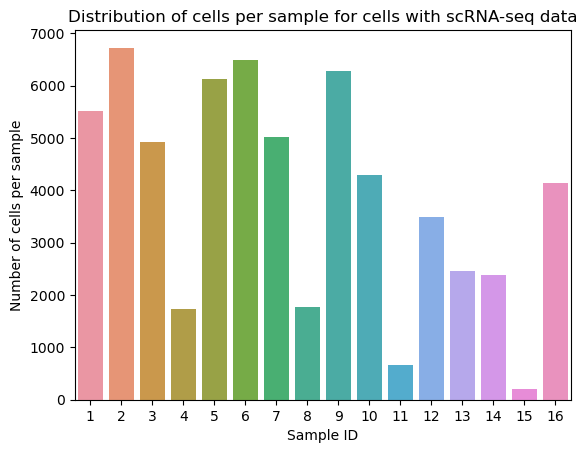

In [5]:
# First trim expr file so it is more manageable
! head -10 GSE125881_raw.expMatrix.csv > expMatrix_first_10_lines.csv

expr_mat = pd.read_csv("expMatrix_first_10_lines.csv", index_col=0)
all_barcodes_w_expr = set(expr_mat.columns)
print(f"There are {len(expr_mat.columns)} cells in the dataset")

barcode_counts_per_sample_sc = {}
for code in all_barcodes_w_expr:
    sample_id = int(code.split("-")[-1])
    barcode_counts_per_sample_sc[sample_id] = barcode_counts_per_sample_sc.get(sample_id, 0) + 1

sns.barplot(x=list(barcode_counts_per_sample_sc.keys()), y=list(barcode_counts_per_sample_sc.values()))
plt.xlabel("Sample ID")
plt.ylabel("Number of cells per sample")
plt.title("Distribution of cells per sample for cells with scRNA-seq data")
plt.show()

### Find overlap between TCR and sc data

There are 53032 TCR barcodes, 62167 scRNA-seq barcodes
And there are 52637 barcodes that are in both the TCR-seq and scRNA-seq data
That is 84.67% overlap


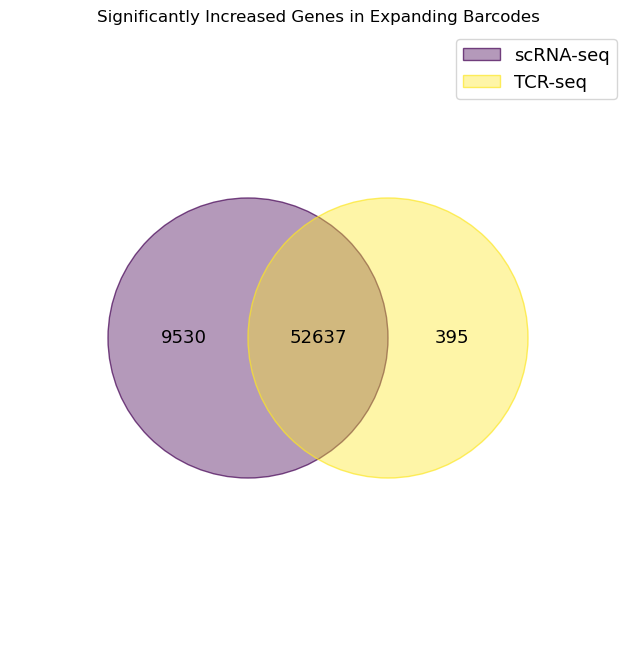

In [6]:

# Check overlap between new barcodes and expr matrix codes
overlapping_barcodes = all_barcodes_w_tcr & all_barcodes_w_expr 
overlap_btwn_tcr_and_expr_mat_barcodes = len(overlapping_barcodes)
print(f"There are {len(all_barcodes_w_tcr)} TCR barcodes, {len(all_barcodes_w_expr)} scRNA-seq barcodes")
print(f"And there are {overlap_btwn_tcr_and_expr_mat_barcodes} barcodes that are in both the TCR-seq and scRNA-seq data")
print(f"That is {len(overlapping_barcodes)/len(all_barcodes_w_expr)*100:.02f}% overlap")


venn({"scRNA-seq": set(all_barcodes_w_expr), "TCR-seq": set(all_barcodes_w_tcr)}) # fmt="{percentage:.1f}%",
plt.title("Significantly Increased Genes in Expanding Barcodes")
plt.show()

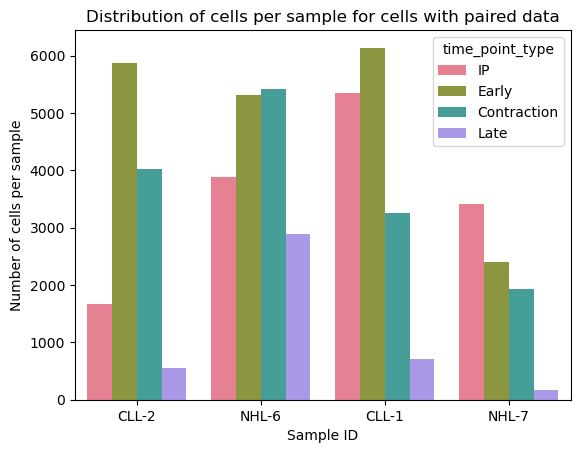

In [7]:
barcode_counts_per_sample_tcr = {}
for code in all_barcodes_w_tcr:
    sample_id = int(code.split("-")[-1])
    barcode_counts_per_sample_tcr[sample_id] = barcode_counts_per_sample_tcr.get(sample_id, 0) + 1

barcode_data = pd.DataFrame(barcode_counts_per_sample_tcr.items(), columns=["sample_id", "barcode_count"])

barcode_data["patient_id"] = barcode_data["sample_id"].map(id_to_patient_id)
barcode_data["time_point_type"] = barcode_data["sample_id"].map(id_to_time_pt)

sns.barplot(data=barcode_data, x="patient_id", y="barcode_count", hue="time_point_type", hue_order=["IP", "Early", "Contraction", "Late"], palette="husl")
plt.xlabel("Sample ID")
plt.ylabel("Number of cells per sample")
plt.title("Distribution of cells per sample for cells with paired data")
plt.show()

In [8]:
# Trim the expression matrix to only include the barcodes that are also in the TCR-seq data
expr_mat = expr_mat.loc[:, overlapping_barcodes]

/var/folders/pf/xdq1hzpd1sg02zxbtb77nhm80000gn/T/ipykernel_43680/3325477373.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  expr_mat = expr_mat.loc[:, overlapping_barcodes]


### Sanity check that our method of matching lead to correct matches
* We found that when we change the UMIs in the TCR data to have their sample IDs (derived from GEO) instead of all ending with -1 (as they originally did), we see a high level of overlap with the UMIs found in the expression data (84.67%). This degree of overlap gave us confidence that we were assigning the labels correctly and that this was a reasonable way to pair the TCR and single cell data.
* However, we were worried that maybe these IDs didn't mean what we thought they did and that it would have been possible to get 84% overlap between the single cell and TCR UMIs even if we had incorrectly or arbitrarily assigned sample IDs to UMIs. To check if this was the case, we investigated the null hypothesis that the assigned labels had no real meaning to them.
* Specifically, we randomly shuffled the labels and re-assigned them then calculated the overlap between the TCR and scRNA-seq UMIs. We repeated this 1000 times with different initializations to create a null distribution. Our observed overlap of 52637 UMIs is significantly outside of the null distribution p<0.001 which made us feel confident moving forward with the analysis knowing that we paired the TCR and expression data in a reasonable way

In [9]:
barcodes_per_tcr_file = []

for file in os.listdir(raw_file_folder):
    if file.endswith(".csv.gz"):
        gsm_name = file.split("_")[0]
        df = pd.read_csv(os.path.join(raw_file_folder, file), compression="gzip", sep=",")
        barcodes_per_tcr_file.append(df["barcodes"].str.split(";").explode().unique())


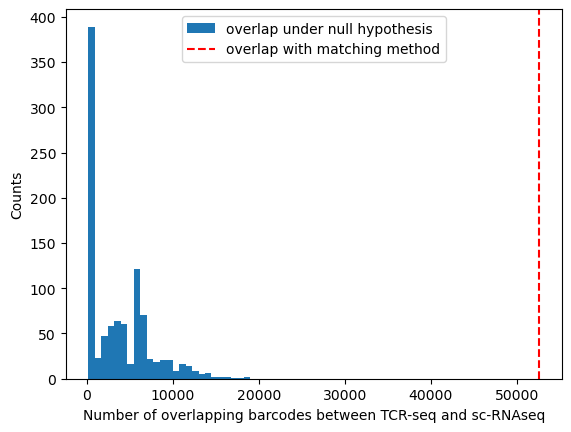

In [10]:
overlaps = []
for _ in range(1000):
    random_sample_ids = list(range(1, 17))
    random.shuffle(random_sample_ids)
    random_sample_ids

    all_barcodes_w_tcr_null_dist = set()
    for barcodes_in_file, sample_id in zip(barcodes_per_tcr_file, random_sample_ids):
        updated_barcodes = set(f"{code.split('-')[0]}-{sample_id}" for code in barcodes_in_file)
        all_barcodes_w_tcr_null_dist.update(updated_barcodes)

    # Check overlap between new barcodes and expr matrix codes
    overlaps.append(len(all_barcodes_w_tcr_null_dist & all_barcodes_w_expr))

plt.hist(overlaps, bins=25, label="overlap under null hypothesis")
plt.axvline(overlap_btwn_tcr_and_expr_mat_barcodes, color="red", label="overlap with matching method", linestyle="--")
plt.legend()
plt.xlabel("Number of overlapping barcodes between TCR-seq and sc-RNAseq")
plt.ylabel("Counts")
plt.show()

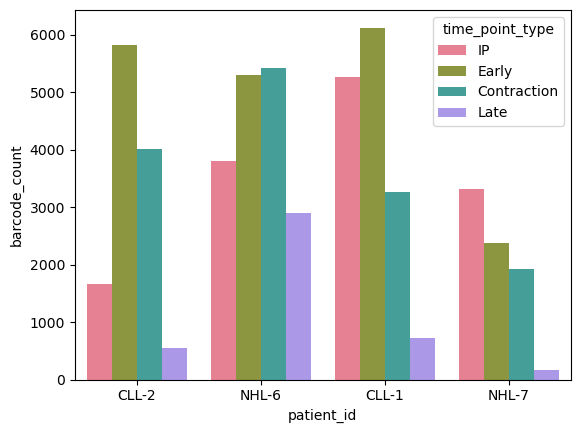

In [14]:
barcode_counts_per_sample_tcr = {}
for code in overlapping_barcodes:
    sample_id = int(code.split("-")[-1])
    barcode_counts_per_sample_tcr[sample_id] = barcode_counts_per_sample_tcr.get(sample_id, 0) + 1

barcode_data = pd.DataFrame(barcode_counts_per_sample_tcr.items(), columns=["sample_id", "barcode_count"])

barcode_data["patient_id"] = barcode_data["sample_id"].map(id_to_patient_id)
barcode_data["time_point_type"] = barcode_data["sample_id"].map(id_to_time_pt)

sns.barplot(data=barcode_data, x="patient_id", y="barcode_count", hue="time_point_type", hue_order=["IP", "Early", "Contraction", "Late"], palette="husl")
plt.show()

### Create mapping from barcodes to clonotypes

In [52]:
barcode_clonotype_list = []
for fn in os.listdir("GSE125881_RAW"):
    if not fn.endswith(".csv.gz"):
        continue

    # read in tcr file and get metadata
    tcr_df = pd.read_csv(f"GSE125881_RAW/{fn}", compression="gzip", sep=",").query("chain == 'TRB'").reset_index(drop=True)
    gsm_id = fn.split("_")[0]
    sample_id = str(gsm_to_id[gsm_id])

    # df_idx_to_cdr3_seq = tcr_df["cdr3s"].to_dict()

    # add sample id metadata to barcodes and clonotype idx
    barcode_idx_df = tcr_df.set_index("cdr3s")["barcodes"].str.split(";").explode().reset_index()
    # barcode_idx_df["cdr3s"] = [df_idx_to_cdr3_seq[i] for i in tcr_df["barcodes"].str.split(";").explode().index]
    # break
    # barcode_idx_df.reset_index(drop=True, inplace=True)
    barcode_idx_df["barcodes"] = barcode_idx_df["barcodes"].apply(lambda x: x.split("-")[0] + "-" + sample_id)
    # barcode_idx_df["index"] = barcode_idx_df["index"].apply(lambda x: f"{sample_id}-{x}") 
    barcode_idx_df["gsm_name"] = gsm_id
    barcode_idx_df["id_in_expmatrix"] = int(sample_id)

    barcode_clonotype_list.append(barcode_idx_df)

barcode_clonotype_df = pd.concat(barcode_clonotype_list, axis=0).reset_index(drop=True)

print(f"There are {len(barcode_clonotype_df)} barcodes in the TCR-seq data")
duplicated_barcodes = barcode_clonotype_df[barcode_clonotype_df['barcodes'].duplicated()]
print(f"There are {len(duplicated_barcodes['barcodes'].unique())} barcodes that occur more than once") 
barcode_clonotype_df = barcode_clonotype_df.drop_duplicates(subset="barcodes", keep=False)
print(f"Now there are {len(barcode_clonotype_df)} barcodes in the TCR-seq data")
barcode_clonotype_df = barcode_clonotype_df.rename(columns={"barcodes": "barcode", "cdr3s": "cdr3"})

There are 53242 barcodes in the TCR-seq data
There are 1863 barcodes that occur more than once
Now there are 49467 barcodes in the TCR-seq data


### Create unique integer id for each cdr3 within each patient

In [53]:
barcode_clones = barcode_clonotype_df.merge(meta, on=["gsm_name", "id_in_expmatrix"])
groups_w_clone_ids = []
for patient_id, group in barcode_clones.groupby("patient_id"):
    group_copy = group.copy()
    cdr3_to_id = dict((seq, f"{patient_id}-{i}") for i, seq in enumerate(group["cdr3"].unique()))
    group_copy["clone_id"] = group_copy["cdr3"].apply(lambda x: cdr3_to_id[x])
    groups_w_clone_ids.append(group_copy)

barcodes_df_w_clone_ids = pd.concat(groups_w_clone_ids)

barcodes_df_w_clone_ids.to_csv("barcode_clonotypes.csv", index=False)